In [1]:
import logging
from typing import Any, Dict, Optional

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin

import dataflow.core as dtfcore
import dataflow.core.node as dtfcornode
import dataflow.core.nodes.sklearn_models as dtfcnoskmo
import dataflow.core.nodes.sources as dtfconosou
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import research_amp.soccer_prediction.preproccesing as rasoprpr
import research_amp.soccer_prediction.utils as rasoprut
import research_amp.soccer_prediction.models as rasoprmo

/app/dataflow/core/dag.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [ ]:
hdbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

In [ ]:
# Define the necessary preprocessing step configuration.
config = {"load_and_preprocess_node": {"bucket_name": "cryptokaizen-data-test", "dataset_path": "kaizen_ai/soccer_prediction/datasets/OSF_football/ISDBv2.txt"}}
node_1 = "load_and_preprocess_node"
# Initialize the FunctionDataSource with the correct configuration.
load_and_preprocess_node = dtfconosou.FunctionDataSource(
    node_1, 
    func=rasoprpr.load_and_preprocess_data, 
    func_kwargs=config[node_1]
    )
preprocessed_df_out = load_and_preprocess_node.fit()["df_out"]

In [4]:
_LOG.debug(hpandas.df_to_str(preprocessed_df_out))

,season,league,Date,home_team,opponent,goals_scored_by_home_team,goals_scored_by_opponent,goal_difference,match_outcome
2000-03-19 00:00:00,00-01,CHN1,2000-03-19 00:00:00,Dalian Haichang,Beijing Guoan,2,0,2,win
2000-03-19 02:00:00,00-01,CHN1,2000-03-19 00:00:00,Shandong Luneng,Yunnan Hongta,0,1,-1,loss
2000-03-19 04:00:00,00-01,CHN1,2000-03-19 00:00:00,Guangzhou Rich and Force,Chongqing Lifan,0,0,0,draw
,...,...,...,...,...,...,...,...,...
2017-06-27 08:00:00,16-17,ARG1,2017-06-27 00:00:00,Estudiantes,Quilmes AC,1,0,1,win
2017-06-28 00:00:00,16-17,ARG1,2017-06-28 00:00:00,Talleres Cordoba,San Lorenzo,1,1,0,draw
2017-06-28 02:00:00,16-17,ARG1,2017-06-28 00:00:00,Independiente,CA Lanus,1,1,0,draw


DEBUG None


#### Bivariate model Node

In [5]:
# Define node ID and variables.
node_3 = dtfcornode.NodeId("poisson_regressor")
# Instantiate the ContinuousSkLearnModel with the bivariate Poisson wrapper.
poisson_model_node = rasoprmo.BivariatePoissonModel(
    nid=node_3,
    maxiter = 1
)
df_model_fit = poisson_model_node.fit(preprocessed_df_out[:1000])["df_out"]
_LOG.debug(hpandas.df_to_str(df_model_fit))

INFO  Current params: [-0.98123985  0.17794165  0.1         0.99497873  0.99158465  0.99195713
  0.98977155  0.99072085  0.98869852  0.98838818  0.99001746  0.98743943
  0.9906817   0.99621826  0.99201925  0.98712014  0.98941402  0.98798548
  0.99239562  0.98916937  0.99183986  0.98588998  0.99146079  0.9889504
  0.99331051  0.9895311   0.98887052  0.98809132  0.98539987  0.99193121
  0.98871588  0.98767968  0.99276473  0.99163757  0.99063411  0.99539717
  0.99067112  0.99197124  0.99312419  0.99422543  0.98870039  0.99256356
  0.99413457  0.99322914  0.99280565  0.99351359  0.99453593  0.99696276
  0.99514899  0.99732233  0.99665548  0.99857821  0.99387443  0.99631191
  0.99595264  0.99893727  0.9934855   0.99520917  0.99668054  0.99681158
  0.99628599  0.99808228  0.99810499  0.99712701  0.99484665  0.99573785
  0.99738524  0.99605504  0.99480455  1.0006991   0.99778017  0.9969825
  0.99905752  0.99751273  0.99706406  0.99818757  0.99782781  0.99585765
  0.99625693  0.99858614  0.996

,prob_win,prob_loss,prob_draw
2000-03-19 00:00:00,0.445854,0.257736,0.296409
2000-03-19 02:00:00,0.445366,0.257579,0.297054
2000-03-19 04:00:00,0.44469,0.258467,0.296842
,...,...,...
2000-08-27 20:00:00,0.445773,0.258504,0.295722
2000-08-27 22:00:00,0.445834,0.258455,0.295711
2000-08-28 00:00:00,0.446185,0.258283,0.295531


DEBUG None


In [6]:
# # Combine Predictions and calculate match outcomes.
# node_4 = "match_outcomes_node"
# config = {"match_outcomes_node": {"actual_df": df_out_fit, "predictions_df": df_model_predict}}
# # Calculate match outcomes.
# match_outcomes_node = dtfconosou.FunctionDataSource(
#     node_4, 
#     func=rasoprut.calculate_match_outcome_probabilities, 
#     func_kwargs=config[node_4]
#     )
# match_outcomes_df_out = preprocessing_node.fit()["df_out"]
# _LOG.debug(hpandas.df_to_str(preprocessing_df_out))

### Intiating DAG

In [7]:
name = "soccer_prediction"
dag = dtfcore.DAG(name=name, mode = "loose")
# Note that DAG objects can print information about their state.
display(dag)

DEBUG name='soccer_prediction', mode='loose'
DEBUG save_node_io='', save_node_df_out_stats=False, profile_execution=False, dst_dir=None


<dataflow.core.dag.DAG at 0x7facbe855610>:
  _nx_dag='DiGraph with 0 nodes and 0 edges' <networkx.classes.digraph.DiGraph>
  _name='soccer_prediction' <str>
  _mode='loose' <str>
  _save_node_io='' <str>
  _save_node_df_out_stats='False' <bool>
  _profile_execution='False' <bool>
  _dst_dir='None' <NoneType>
  force_free_nodes='False' <bool>
  nodes=[]
  edges=[]
  json=
  {
      "directed": true,
      "graph": {},
      "links": [],
      "multigraph": false,
      "nodes": []
  }

In [8]:
# Append dag with nodes.
dag.append_to_tail(load_and_preprocess_node)
dag.append_to_tail(poisson_model_node)
#dag.append_to_tail(combine_predictions_node)
display(dag)

<dataflow.core.dag.DAG at 0x7facbe855610>:
  _nx_dag='DiGraph with 2 nodes and 1 edges' <networkx.classes.digraph.DiGraph>
  _name='soccer_prediction' <str>
  _mode='loose' <str>
  _save_node_io='' <str>
  _save_node_df_out_stats='False' <bool>
  _profile_execution='False' <bool>
  _dst_dir='None' <NoneType>
  force_free_nodes='False' <bool>
  nodes=[('load_and_preprocess_node', {'stage': <dataflow.core.nodes.sources.FunctionDataSource object at 0x7facfba28d60>}), ('poisson_regressor', {'stage': <research_amp.soccer_prediction.models.BivariatePoissonModel object at 0x7fad3692a040>})]
  edges=[('load_and_preprocess_node', 'poisson_regressor', {'df_in': 'df_out'})]
  json=
  {
      "directed": true,
      "graph": {},
      "links": [
          {
              "df_in": "df_out",
              "source": "load_and_preprocess_node",
              "target": "poisson_regressor"
          }
      ],
      "multigraph": false,
      "nodes": [
          {
              "id": "load_and_preproce

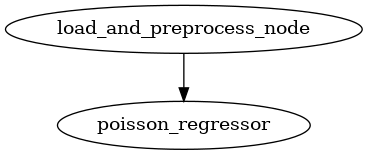

In [9]:
dtfcore.draw(dag)